In [126]:
"""
Jules Faucher
260926201

Phys 512
November 5, 2021
"""

import h5py
import numpy as np
import scipy.interpolate as sci
import matplotlib.pyplot as plt
import os

files = os.listdir()
templates = [e for e in files if e[-13:] == "template.hdf5"] #Collecting all similar files together
H_files = [e for e in files if e[:9] == "H-H1_LOSC"]
L_files = [e for e in files if e[:9] == "L-L1_LOSC"]
loc_name = ["Hanford", "Livingston"]

coord = [3, 0, 2, 1] #This list relates the strains with the correct templates 

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

def flat_cos(n, m): #Function used as a window
    x=np.linspace(-np.pi,np.pi,m)
    tips = 0.5 + 0.5*np.cos(x)
    flat = np.ones(n)
    half_m = m//2
    flat[:half_m] = tips[:half_m]
    flat[-half_m:] = tips[-half_m:]
    return flat

Gaussian = lambda x, mu, sigma : np.exp( -0.5*((x-mu)/sigma)**2 )/np.sqrt(2*np.pi)/sigma
xcr = lambda a, b : np.irfft(np.rfft(a) * np.conj(np.rfft(b))) #cross-correlation of a and b
spec = lambda a: np.abs(np.fft.rfft(a))**2 #power spectrum of a

### 1. Noise Model
The first step in finding an appropriate noise model is finding an appropriate window function. An ideal window function will not affect the main frequencies of the signal we are trying to find. I will use a cosine function with a flat middle section. By trial, and error, I will find the best parameter for which the main part of the GW signal is conserved. Below, you can see that using 1/8 of the window's array for the cosine part does a good job a keeping the GW signal in good condition.

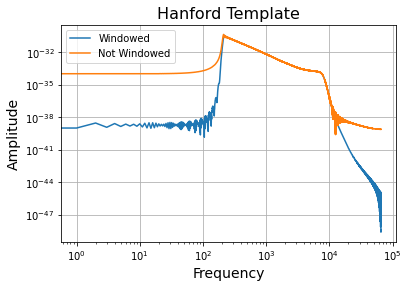

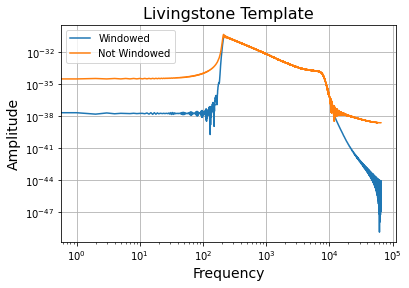

In [127]:
th, tl = read_template(templates[0]) #Taking the first event as an example
lent = len(th)

window = flat_cos(lent, lent//8)

tempH_PS = spec(th*window)
tempL_PS = spec(tl*window)

tempH_PS_noWindow = spec(th)
tempL_PS_noWindow = spec(tl)

plt.loglog(tempH_PS, label = "Windowed")
plt.loglog(tempH_PS_noWindow, label = "Not Windowed")
plt.title("Hanford Template", fontsize = 16)
plt.xlabel("Frequency", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

plt.loglog(tempL_PS, label = "Windowed")
plt.loglog(tempL_PS_noWindow, label = "Not Windowed")
plt.title("Livingstone Template", fontsize = 16)
plt.xlabel("Frequency", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

To create a noise model, the power spectrums of the four strains of each detectors were averaged. Then, this avergage was convoluted with a box to smooth out the small peaks in the model, while keeping the large peaks intact. 

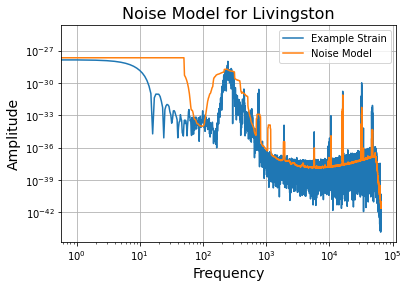

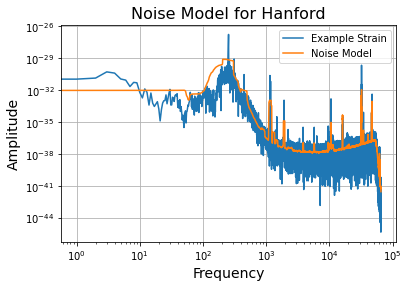

In [132]:
def get_noise(location):
    
    files = [H_files, L_files]
    
    strain, dt, utc = read_file(files[location][0])
    lenS = len(strain)

    wind = flat_cos(lenS, lenS//8)
    avg_PS = 0

    for f in files[location]:
        
        strain, dt, utc = read_file(f)
        avg_PS += 0.25*spec(strain*wind)

    avg_PS = np.convolve(avg_PS, np.ones(100)/100, mode = 'same')

    return avg_PS


event = 0
files = [H_files, L_files]
strainH, dt, utc = read_file(files[0][event])
strainL, dt, utc = read_file(files[1][event])
lenS = len(strainH)
wind = flat_cos(lenS, lenS//8)

noise_model_L = get_noise(1)
noise_model_H = get_noise(0)

plt.loglog(spec(strainL*wind), label = "Example Strain")
plt.loglog(noise_model_L, label = "Noise Model")
plt.title("Noise Model for Livingston", fontsize = 16)
plt.xlabel("Frequency", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

plt.loglog(spec(strainH*wind), label = "Example Strain")
plt.loglog(noise_model_H, label = "Noise Model")
plt.title("Noise Model for Hanford", fontsize = 16)
plt.xlabel("Frequency", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)
plt.legend()
plt.grid()
plt.show()

### 2. Match Filtering
The mapping between the events and the template were summarized in the "coord" list

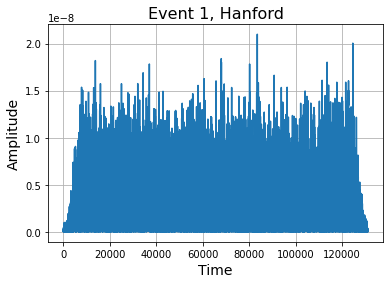

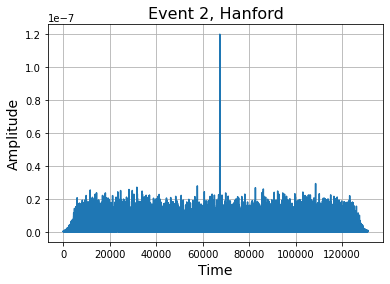

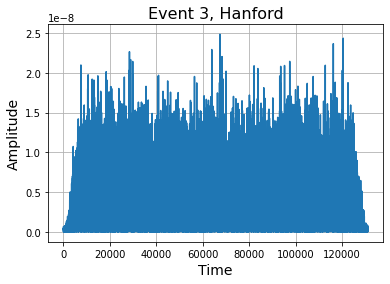

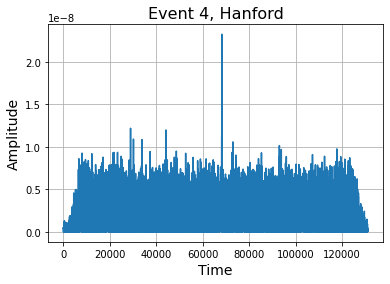

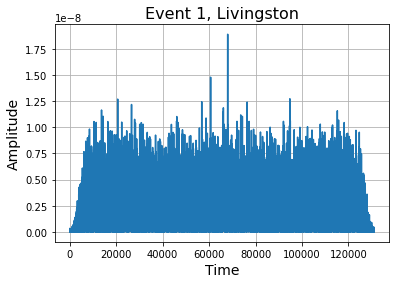

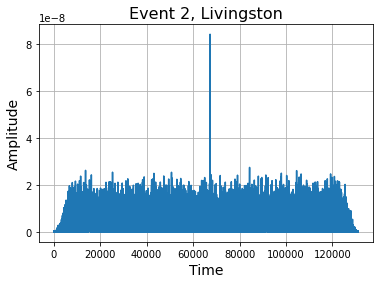

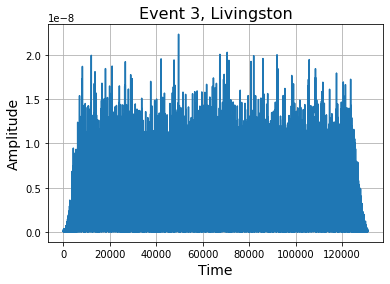

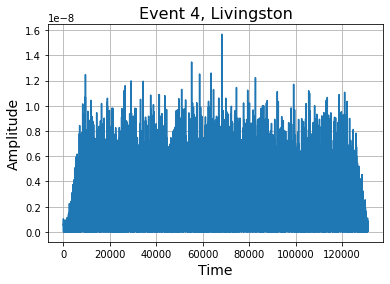

In [133]:
def match_filter(events, location):
    
    files = [H_files, L_files][location]

    data, dt, utc = read_file(files[events])
    t = read_template(templates[coord[event]])[location]

    if location == 0:
        noise = np.sqrt(noise_model_H)
    else:
        noise = np.sqrt(noise_model_L)


    t_len = len(t)
    wind = flat_cos(t_len, t_len//8) #window
    temp_fft = np.fft.rfft(t*wind)
    temp_white = temp_fft/noise/4096
    
    lenData = len(data)
    window = flat_cos(lenData, lenData//8)
    data_fft = np.fft.rfft(data*window)
    data_white = data_fft/noise/4096

    MF = np.fft.irfft(data_white * np.conj(temp_white))
    MF_show = np.roll(np.abs(MF), len(MF)//2)
    
    return MF_show


for loc in [0, 1]:
    for event in range(4):
        
        MF = match_filter(event, loc)
        
        plt.plot(MF)
        plt.title("Event " + str(event+1) + ", " + loc_name[loc], fontsize = 16)
        plt.xlabel("Time", fontsize = 14)
        plt.ylabel("Amplitude", fontsize = 14)
        plt.grid()
        plt.show()

### 3. Signal-to-Noise Ratio (SNR)
We can estimate that the noise is gaussian in the above results. As such, the standard deviations of the matched filtered data can give us an approximation of the noise's applitude. 

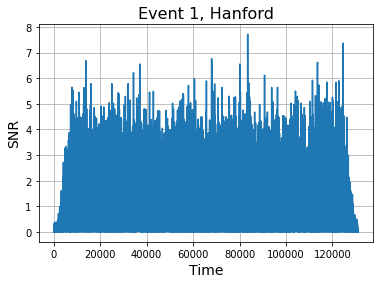

SNR = 7.713295877436378


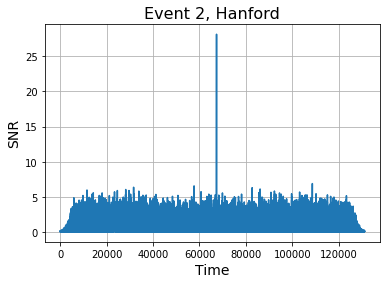

SNR = 28.150733859321836


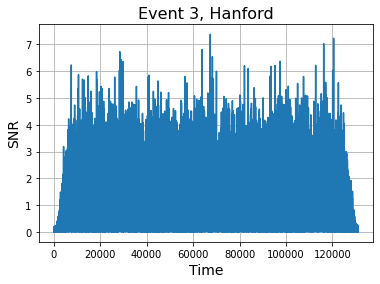

SNR = 7.374815102218968


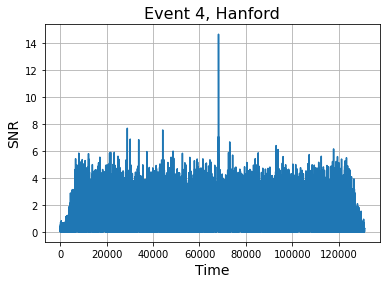

SNR = 14.641882340329742


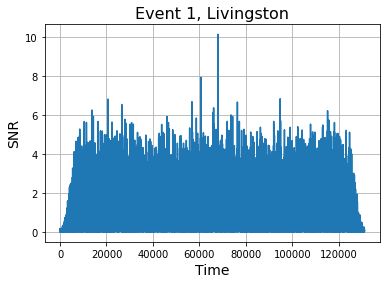

SNR = 10.149546779125263


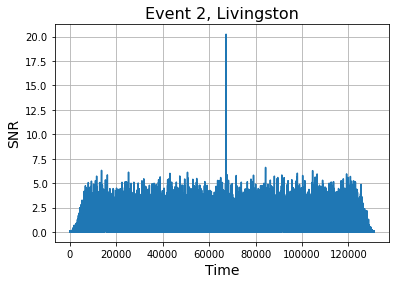

SNR = 20.24292987266454


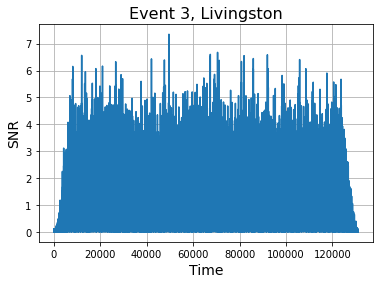

SNR = 7.348373345612901


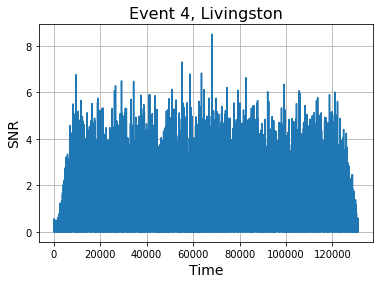

SNR = 8.490966197459358


In [135]:
for loc in [0, 1]:
    for event in range(4):
        
        MF = match_filter(event, loc)
        SNR = MF/np.std(MF)
        
        plt.plot(SNR)
        plt.title("Event " + str(event+1) + ", " + loc_name[loc], fontsize = 16)
        plt.xlabel("Time", fontsize = 14)
        plt.ylabel("SNR", fontsize = 14)
        plt.grid()
        plt.show()
        
        print("SNR =", np.amax(SNR))

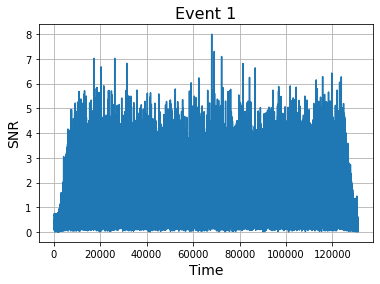

SNR = 7.997444455131213


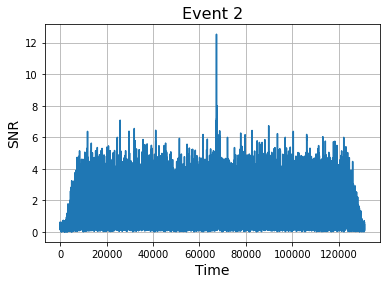

SNR = 12.53136398851763


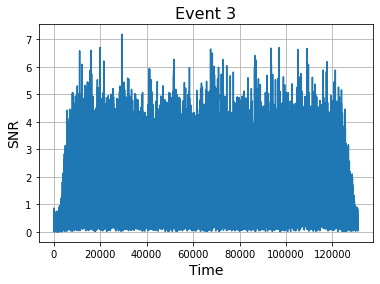

SNR = 7.180650989574755


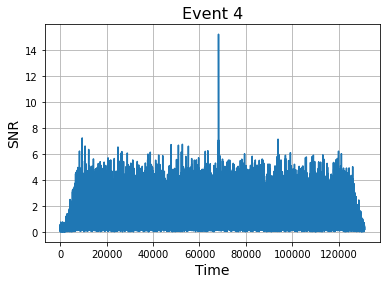

SNR = 15.2075072958606


In [139]:
for i in range(4):

    MF_combined = match_filter(i, 0) + match_filter(i, 1)
    SNR = MF_combined/np.std(MF_combined)
    plt.plot(SNR)
    plt.title("Event " + str(i+1), fontsize = 16)
    plt.xlabel("Time", fontsize = 14)
    plt.ylabel("SNR", fontsize = 14)
    plt.grid()
    plt.show()
    print("SNR =", np.amax(SNR))

### 4. Comparing Theoritical Noise and SNR
The analytic noise is obtained by withening templates and correleting them to themselves.

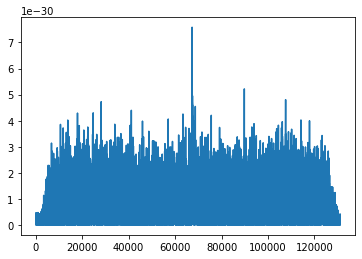

In [156]:
th, tl = read_template(templates[0])
noise = get_noise(0)
window = flat_cos(len(th), len(th//8))
th_noise = np.fft.irfft(np.fft.rfft(th*window)/noise * np.conj(np.fft.rfft(th*window)/noise))
sig_H = np.sqrt(np.sum(np.abs(th_noise)))

MF = match_filter(1, 0)/sig_H

plt.plot(MF)

### 5.  Weight

In [113]:
event = 0

noise_H = get_noise(0)
noise_L = get_noise(1)
th, tl = read_template(templates[coord[event]])

Len = len(th)
wind = flat_cos(Len, Len//8)

th_white = np.abs(np.fft.rfft(th*wind)/noise_H)**2

cumsum_th = np.cumsum(th_white)
half_pow_th = cumsum_th[-1]/2
id_weight_h = np.where(cumsum_th > half_pow_th)
freq_half_pow_h = np.fft.rfftfreq(len(th), 1/4096)[id_weight_h][0]
freq_half_pow_h

117.6875

### 6. Time of Arrival
We need to compute the time elapsed between the two peaks observed at different locations. Here is an example with the second event.

In [158]:
MF_H = match_filter(1, 0)
MF_L = match_filter(1, 1)

id_max_H = np.where(MF_H==np.amax(MF_H))
id_max_L = np.where(MF_L==np.amax(MF_L))

print(abs(id_max_H[0] - id_max_L[0])[0]/4096, 'seconds between both detections.')

0.003662109375 seconds between both detections.


Modern GPS technology can allow us to measure the distance between the two detectors very accurately, with an uncertainty of only a couple of meters. This means that the main source of error comes from the measurement of the time of arrival. This time has a minimum uncertainty of $1/f_s$ (2e-4 seconds). If that is the case, we can conclude that the time measurement should be fairly accurate.   